In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import json
from sharedcontrolpaper.force_sensitive_stopping_task_utils import plot_trial_pressure_individual_for_figure_2, plot_figure_3_and_4, create_summary_df_for_figure_3_and_4, convert_formats_back, rename_index_column

In [2]:
parent_directory = os.path.dirname(os.getcwd())

In [3]:
warnings.filterwarnings('ignore') # Ignore warnings

## Load data from JSON files

In [4]:
with open('force_sensitive_data.json', 'r') as f:
    loaded_data = json.load(f)

duration_of_inhibition = pd.DataFrame.from_records(loaded_data['duration_of_inhibition'])
shared_control_metrics = convert_formats_back(loaded_data['shared_control_metrics'])

with open('merged_df.json', 'r') as f:
    loaded_data = json.load(f)

merged_df = pd.DataFrame.from_records(loaded_data['merged_df'])
rename_index_column(merged_df)
rename_index_column(duration_of_inhibition)

## Figure 2: A canonical trial

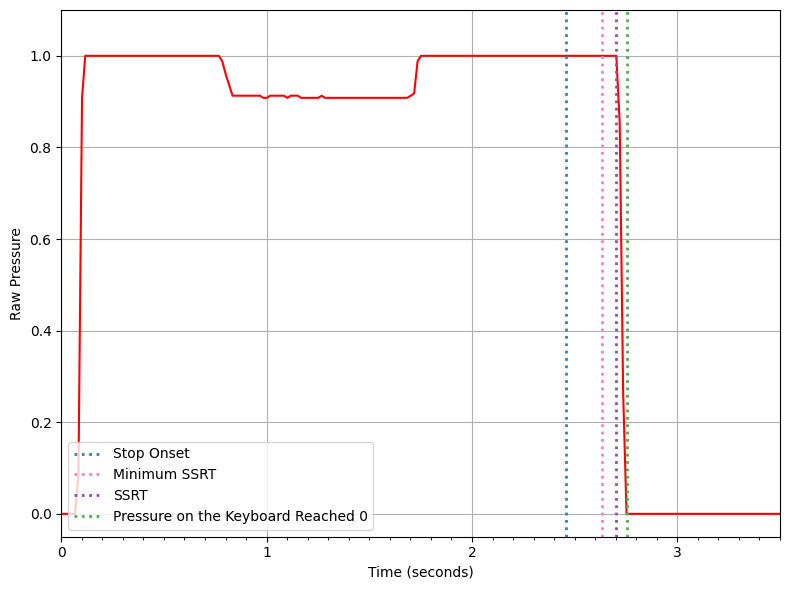

In [5]:
trial_results = shared_control_metrics['s007']['Non-AI']['trial_results']
target_trial_num = 20 # We want to plot this trial specifically
trial_data = trial_results[str(target_trial_num)]
plt.figure(figsize=(8, 6))
if trial_data:
    ax = plt.gca()
    plot_trial_pressure_individual_for_figure_2(trial_data, target_trial_num, ax, color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Raw Pressure')
    plt.savefig(f'{parent_directory}/figures/figure2.png')
    plt.tight_layout()
    plt.show()

## Figure 3: Non-AI vs AI-Disengaged SSRT

In [6]:
custom_names = {'non_ai': 'Non-AI', 'ai_failed': 'AI-failed'}
desired_order = ['Non-AI', 'AI-failed']

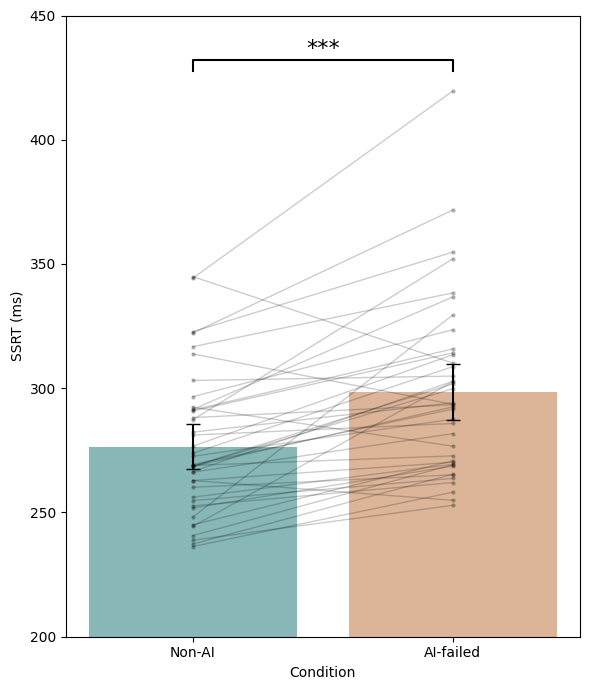

In [7]:
merged_df.reset_index(inplace=True)
melted_ssrt, summary_ssrt = create_summary_df_for_figure_3_and_4(merged_df, 'SSRT', custom_names, desired_order)
plot_figure_3_and_4(melted_ssrt, summary_ssrt, 'SSRT', 'SSRT (ms)', f'{parent_directory}/figures/figure3.png', ylim=(200, 450))

## Figure 4: Non-AI vs AI-Disengaged Duration of Inhibition

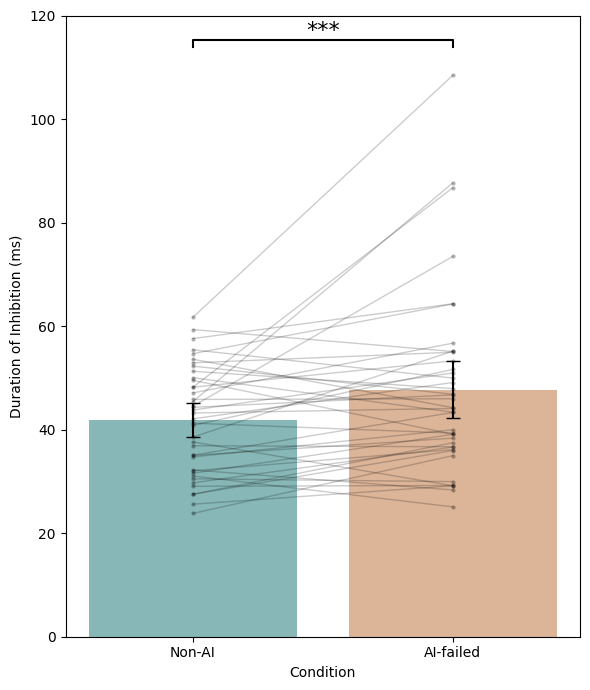

In [8]:
duration_of_inhibition.reset_index(inplace=True)
melted_duration, summary_duration = create_summary_df_for_figure_3_and_4(duration_of_inhibition, 'Duration of Inhibition', custom_names, desired_order)
plot_figure_3_and_4(melted_duration, summary_duration, 'Duration of Inhibition', 'Duration of Inhibition (ms)', f'{parent_directory}/figures/figure4.png', ylim=(0, 120))